In [31]:
import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt

from qiskit import Aer
from tqdm.notebook import tqdm
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

import sys
sys.path.insert(0, '../../src/')
from neuralnetwork import *
from analysis import *

#%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=4, suppress=None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
backend = Aer.get_backend('qasm_simulator')

# Breast Cancer Data

### Load Data

In [5]:
data = load_breast_cancer()
x = data.data
y = data.target.reshape(-1, 1)

np.random.seed(42)
x, _, y, _ = train_test_split(x, y, train_size=100)

## Three First Variables

In [6]:
x_three_first = x[:,:3]

In [ ]:
y_dnn = y
y_qnn = y

x_qnn = scaler(x_three_first, mode="uniform", a=0, b=np.pi)
x_dnn = scaler(x_three_first, mode="standard")

In [ ]:
np.random.seed(42)

dnn_list = []
for i in tqdm(range(10)):
    dnn = sequential_dnn(dim = [3, 5, 1], lr = 0.1)
    dnn.train(x_dnn, y_dnn, epochs = 100)
    dnn_list.append(dnn)
    
saver(dnn_list, data_path("cancer_dnn_three_first"))

In [ ]:
np.random.seed(42)

qnn_list = []
for i in tqdm(range(5)):
    qnn = sequential_qnn(q_bits = [3, 3],
                         dim = [3, 3, 1],
                         reps = 2,
                         backend=backend,
                         shots=10000,
                         lr = 0.1)
    qnn.train(x_qnn, y_qnn, epochs=100, verbose=True)
    qnn_list.append(qnn)

saver(qnn_list, data_path("cancer_qnn_three_first"))

## PCA

In [ ]:
x_scaled = scaler(x, mode="standard")
pca = PCA(n_components=3)
x_pca = pca.fit_transform(x_scaled)

In [ ]:
y_dnn = y
y_qnn = y

x_qnn = scaler(x_pca, mode="uniform", a=0, b=np.pi)
x_dnn = scaler(x_pca, mode="standard")

In [ ]:
plt.plot(x_qnn[:,1], y_dnn,"o")

In [ ]:
np.random.seed(42)

dnn_list = []
for i in tqdm(range(10)):
    dnn = sequential_dnn(dim = [3, 5, 1], lr = 0.1)
    dnn.train(x_dnn, y_dnn, epochs = 100)
    dnn_list.append(dnn)
    
saver(dnn_list, data_path("cancer_dnn_pca"))

In [ ]:
np.random.seed(42)

qnn_list = []
for i in tqdm(range(5)):
    qnn = sequential_qnn(q_bits = [3, 3],
                         dim = [3, 3, 1],
                         reps = 2,
                         backend=backend,
                         shots=10000,
                         lr = 0.1)
    qnn.train(x_qnn, y_qnn, epochs=100, verbose=True)
    qnn_list.append(qnn)

saver(qnn_list, data_path("cancer_qnn_pca"))

## Most Correlated

In [33]:
corr = np.corrcoef(x, y, rowvar=False)[-1,:-1]
idx = (corr).argsort()[:3]
x_corr = x[:, idx]

In [34]:
y_dnn = y
y_qnn = y

x_qnn = scaler(x_corr, mode="uniform", a=0, b=np.pi)
x_dnn = scaler(x_corr, mode="standard")

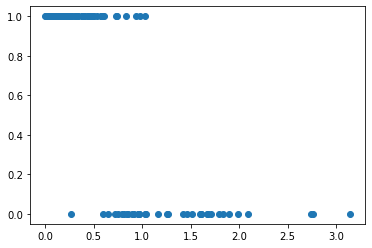

In [35]:
plt.plot(x_qnn[:,2], y_dnn,"o")

In [ ]:
np.random.seed(42)

dnn_list = []
for i in tqdm(range(10)):
    dnn = sequential_dnn(dim = [3, 5, 1], lr = 0.1)
    dnn.train(x_dnn, y_dnn, epochs = 100)
    dnn_list.append(dnn)
    
saver(dnn_list, data_path("cancer_dnn_most_correlated"))

In [ ]:
np.random.seed(42)

qnn_list = []
for i in tqdm(range(5)):
    qnn = sequential_qnn(q_bits = [3, 3],
                         dim = [3, 3, 1],
                         reps = 2,
                         backend=backend,
                         shots=10000,
                         lr = 0.1)
    qnn.train(x_qnn, y_qnn, epochs=100, verbose=True)
    qnn_list.append(qnn)

saver(qnn_list, data_path("cancer_qnn"))

In [ ]:
saver(qnn_list, data_path("cancer_qnn_most_correlated"))

### Hybrid Network

### Two Layers

In [ ]:
np.random.seed(42)

network_list = []
for i in tqdm(range(5)):
    layer1 = QLayer(n_qubits=3, n_features=3, n_targets=3, encoder=Encoder(), ansatz=Ansatz(), sampler=Parity(), reps=2, scale=1, backend=backend, shots=10000)
    layer2 = Dense(n_features=3, n_targets=1, activation=Sigmoid())
    layers = [layer1, layer2]

    network = NeuralNetwork(layers=layers, optimizer = Adam(lr=0.1))
    network.train(x_qnn, y_qnn, epochs=100, verbose=True)
    network_list.append(network)

saver(network, data_path("cancer_hybrid_2_layer"))

### Three Layers

In [ ]:
np.random.seed(42)

network_list = []
for i in tqdm(range(5)):
    layer1 = QLayer(n_qubits=3, n_features=3, n_targets=3, encoder=Encoder(), ansatz=Ansatz(), sampler=Parity(), reps=2, scale=1, backend=backend, shots=10000)
    layer2 = QLayer(n_qubits=3, n_features=3, n_targets=3, encoder=Encoder(), ansatz=Ansatz(), sampler=Parity(), reps=2, scale=1, backend=backend, shots=10000)
    layer3 = Dense(n_features=3, n_targets=1, activation=Sigmoid())
    layers = [layer1, layer2, layer3]

    network = NeuralNetwork(layers=layers, optimizer = Adam(lr=0.1))
    network.train(x_qnn, y_qnn, epochs=100, verbose=True)
    network_list.append(network)

saver(network, data_path("cancer_hybrid_3_layer"))

## Single Circuit

In [28]:
network =sequential_qnn(q_bits = [3],
                         dim = [3, 1],
                         reps = 2,
                         backend=backend,
                         shots=10000,
                         lr = 0.01)

In [29]:
network.train(x_corr[:10,:3], y[:10], verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 0, loss: 0.34442690000000004
epoch: 1, loss: 0.3337255890624999
epoch: 2, loss: 0.3294303312499999
epoch: 3, loss: 0.32065841093749997
epoch: 4, loss: 0.30836661093749995
epoch: 5, loss: 0.30482185624999997
epoch: 6, loss: 0.2988282749999999
epoch: 7, loss: 0.2890089046874999
epoch: 8, loss: 0.28388519999999995
epoch: 9, loss: 0.277210103125
epoch: 10, loss: 0.2742277000000001
epoch: 11, loss: 0.26692630937499995
epoch: 12, loss: 0.262925975
epoch: 13, loss: 0.2583955140625
epoch: 14, loss: 0.25925165625
epoch: 15, loss: 0.2551449390625001
epoch: 16, loss: 0.2517426171875
epoch: 17, loss: 0.24776403281249998
epoch: 18, loss: 0.2457703359375
epoch: 19, loss: 0.24437881718749996
epoch: 20, loss: 0.24184641093749998
epoch: 21, loss: 0.24291711875000002
epoch: 22, loss: 0.24204911093749998
epoch: 23, loss: 0.24209668906250004
epoch: 24, loss: 0.2401705421875
epoch: 25, loss: 0.24239105781249998
epoch: 26, loss: 0.24131652968749995
epoch: 27, loss: 0.2435984625
epoch: 28, loss: 0.241

Exception ignored in: <function _releaseLock at 0x7f97a43a4b80>
Traceback (most recent call last):
  File "/home/kristian/anaconda3/envs/env_qiskit/lib/python3.9/logging/__init__.py", line 223, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


QiskitError: 'Keyboard interrupt in parallel_map.'

In [18]:
y_pred = np.round(network.predict(x_corr[:10,:3]))
print(y_pred)

[[0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]]


In [19]:
print(np.mean(y_pred == y[:10]))

0.4


In [62]:
model = LogisticRegression(random_state=42)
model.fit(x_corr[:8,:3], y[:8,0])

LogisticRegression(random_state=42)

In [63]:
y_pred = model.predict_proba(x_corr[:8,:3])

In [64]:
print(y_pred)

[[0.5004 0.4996]
 [0.4883 0.5117]
 [0.5088 0.4912]
 [0.4881 0.5119]
 [0.4908 0.5092]
 [0.5016 0.4984]
 [0.5109 0.4891]
 [0.5111 0.4889]]


In [65]:
print(y[:8,0])

[1 1 0 1 1 0 0 0]
